In [1]:
import sys
sys.path.append('..')
from src.data.docx  import read_docx,process_docx,find_content
import glob
import json
import os
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")
from src.models.pipeline import pipeline
from src.features.segment_transcript import CreateBlocks
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from gensim import similarities
import re
import statistics
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML
from scipy.stats import entropy

# READ BOOKS OF VIDEOS

In [2]:
'''Defining CONSTS'''
docx_path = '../data/raw/docx'
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')
lemmatizing_method ='lemma' #'stemm'

In [3]:
videos_ids = list(map(lambda fl: fl.split('\\')[-1].split('.')[0],glob.glob(docx_path + '/*')))

In [4]:
desired_videos =['zWg7U0OEAoE']#['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ','zWg7U0OEAoE','tORLeHHtazM'] #['zWg7U0OEAoE','tORLeHHtazM'] #['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ']
videos_ids = list(filter(lambda x: x in desired_videos,videos_ids))

In [5]:
#video_docx = [glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0] for vid in videos_ids]
#docx_db =[read_docx(path) for path in video_docx]

In [6]:
f_read = {
    'statbook':'statbook',
    'Dsa':'Dsa'
}

docxs_chapter_keyword = {
    'statbook':'Topic',
    'Dsa': 'Chapter'
}

In [7]:
video_to_paper = {}
paper_content ={}
for vid in videos_ids:
    doc_path = glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0]
    doc_name = doc_path.split('\\')[-1].split('.')[0]
    video_to_paper[vid] = doc_name    
    if doc_name not in paper_content.keys():    
        full_text,font_sizes = read_docx(doc_path)
        paper_content[doc_name] = find_content(f_read[doc_name],
                                               full_text,
                                               font_sizes,
                                               docxs_chapter_keyword[doc_name],
                                              lemmatizing=lemmatizing_method)

# RESTORE RESULTS FROM TRAINING

In [8]:
'''Select transcript for only wanted videos'''
transcript_filespath = list(filter(lambda x: x.split('\\')[-1].split('.')[0] in videos_ids,transcript_filespath))

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''
def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec
for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])
    

'''Get parameters from training'''
df_results = pd.read_csv('../data/processed/bayesian_opt/phrases/lemmas_adv_propn.csv')
n_largest_res = 3
pipeline_results = df_results[df_results['video'].isin(videos_ids)]\
                .groupby('video')[['video','workflow','params','max_target']]\
                .apply(lambda grp: grp.nlargest(n_largest_res,'max_target')).values.tolist()

pipeline_results = pipeline_results[:-1]#this is for zWg7U0OEAoE

    
    
    
def boundryevaluation(curresults,ground_base,accurrcy_shift = 30):
        true_positive = 0
        false_negative = 0
        false_positive = 0 
        true_positive_list_debug = []
        #false_negative_list_debug = []
        false_positive_list_debug = []
        results = curresults[:]
        
        
        #print('curresults %s' %(curresults))
        #print('ground_base %s ' %(ground_base))
        
        for grb in ground_base:
            is_false_positive = True
            for res in results:     
                if abs(res - grb) < accurrcy_shift:
                    is_false_positive = False
                    true_positive_list_debug.append(res)
                    true_positive+=1
                    results.remove(res)
                    break   
            if is_false_positive:
                false_positive_list_debug.append(grb)
                false_positive+=1
                
        #print("TP: " + str(true_positive_list_debug))
        #print("FP: " + str(false_positive_list_debug))
        #print("FN: " + str(curresults))
        #print('true_positive : %s ' %(true_positive))
        false_negative = len(results) # make sure the true positive are removed from here 
        recall_rate = true_positive/(true_positive + false_negative )
        precision_rate = true_positive/(true_positive + false_positive)
        #print("TP: %s , FP: %s, FN: %s" %(true_positive,false_positive,false_negative))
        #print("precision rate : %s, recall rate : %s " % (precision_rate,recall_rate))
        return precision_rate

    


In [9]:
videos_division = {}

for vid in videos_ids:
    vid_words = None
    vid_shifts = None
    groundbase = [246,415,534,639,783,896,1062,1329,1481,1631,1818,2019,2304,2502,2720,2987,3172]
    transcripts = transcripts_jsons[vid]
    print(vid)
    print(groundbase)
    print(transcripts[-1])
    block_handler = CreateBlocks(transcripts)
    block_as_topics = block_handler.partion_by_timestamp(groundbase)
    vid_words = [list(blk) for blk in block_as_topics]
    groundbase.append('end')
    videos_division[vid] = {'topic_words':vid_words,'topic_shift':groundbase}

zWg7U0OEAoE
[246, 415, 534, 639, 783, 896, 1062, 1329, 1481, 1631, 1818, 2019, 2304, 2502, 2720, 2987, 3172]
{'text': 'and terminology that we be following with\nthis course.', 'start': 3175.91, 'duration': 34.75}


In [10]:
#videos_division

# EXTRACT MAIN CHAPTERS OF BOOKS AND ORAGANIZE THE PAPER AS DIFFERENT DOCUMENTS GROUPS

In [11]:
paper_content[doc_name].keys()

dict_keys(['corpus', 'titles', 'main titles'])

In [12]:
'''Find the following for each paper:
    1) main chapter title index. for example [10,15....]
    2) range of subsection within each main chapter . for example [(0,9),(11,14)...]
    
    '''

#paper_mainchapter_indexes = {}
paper_sec_within_main_indexes = {}
main_section_as_one_doc = {}
paper_subsec_as_one_doc = {}
first_dep_section_as_one_doc = {}

def get_sub_titles(all_titles,main_tl_indexes):
    subsec_mainchapter_indexes = [range(main_tl_indexes[index],main_tl_indexes[index + 1])
                                  for index in range(len(main_tl_indexes) - 1)]
    subsec_mainchapter_indexes.append(range(main_tl_indexes[-1],len(all_titles)))
    return subsec_mainchapter_indexes


for doc_name in paper_content.keys():
    '''
        first element array of subtitles by dividing based on main chapters like 4 number theory
        second element array of subtitles by dividing based on main first hierarchy depth titles like 4.1 simple graph 
    '''
    titles_by_hierchy_ranges = [] 
    titles_by_hierchy_indexes = []
    
    '''Find the main chapter indexes in the list of the overall titles'''
    '''Titles like 4 Number theory or 5 Graphs'''
    mainchapter_indexes = [paper_content[doc_name]['titles'].index(ch_title)
                           for ch_title in paper_content[doc_name]['main titles']]
    titles_by_hierchy_indexes.append(mainchapter_indexes)
    
    '''
        Find the indexes of the first depth subsection
        for example 4.1 simple graphs
    '''
    tl_first_dep_by_hier_indexes = [i for i,tl in enumerate(paper_content[doc_name]['titles'])
     if re.match(r'(^([0-9]+\.[0-9]*)$)',tl) is not None or
     re.match(r'[0-9]+\.[0-9]*\s+',tl) is not None]
    
    titles_by_hierchy_indexes.append(tl_first_dep_by_hier_indexes)
    
    tl_first_dep_by_hier = [tl for i,tl in enumerate(paper_content[doc_name]['titles'])
     if re.match(r'(^([0-9]+\.[0-9]*)$)',tl) is not None or
     re.match(r'[0-9]+\.[0-9]*\s+',tl) is not None]
    
    '''Adding the indexes of the first dep subsections to the main indexes'''
    '''For example the fourth place will contains the indexes of the titles: 4.1,4.2,4.3'''
    top_maintitle_ranges = []

    for index in range(len(mainchapter_indexes) - 1):
        j = mainchapter_indexes[index]
        range_j = []
        while j < mainchapter_indexes[index + 1]:
            '''If this title is from the shape like 4.1 or 4.2'''
            curr_tl = paper_content[doc_name]['titles'][j]
            if j in tl_first_dep_by_hier_indexes:
                range_j.append(tl_first_dep_by_hier.index(curr_tl))
            j+=1
        top_maintitle_ranges.append(range_j)
    '''Adding the last one'''
    j = mainchapter_indexes[-1]
    range_j = []
    while j < len(paper_content[doc_name]['titles']):
        curr_tl = paper_content[doc_name]['titles'][j]
        if j in tl_first_dep_by_hier_indexes:
            range_j.append(tl_first_dep_by_hier.index(curr_tl))
        j+=1
    top_maintitle_ranges.append(range_j)
        
    titles_by_hierchy_ranges.append(top_maintitle_ranges)
    
    '''adding the ranges of the subtitles of the first depth of each '''
    '''like for example for title 4.1 the range will be the indexes of the titles
        4.1.1,4.1.2 etc'''
    titles_by_hierchy_ranges.append(get_sub_titles(paper_content[doc_name]['titles'],
                                                             titles_by_hierchy_indexes[1]))
    
    
    '''Making each chapter as a one documents'''
    
    '''Union all the documents in a atomic section into single document'''
    paper_subsec_as_one_doc[doc_name] = [list(reduce(lambda doc,acc:doc + acc,sec,[]))
                                         for sec in paper_content[doc_name]['corpus']]
    
    
    '''Sections are like 4.1 simple graph'''
    first_dep_section_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                   paper_subsec_as_one_doc[doc_name][s_i]+acc,
                                                    subsec_indexes,[]))
                                        for subsec_indexes in titles_by_hierchy_ranges[1]]

    
    '''Union all the sub section in a main chapter into one document'''
    '''sections are like 4 Number theory'''
    main_section_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                   first_dep_section_as_one_doc[doc_name][s_i]+acc,
                                                    subsec_indexes,[]))
                                        for subsec_indexes in titles_by_hierchy_ranges[0]]
    

In [13]:
#paper_subsec_as_one_doc['statbook'][0]

In [14]:
'''Find phrasers of books  '''
paper_phrasers = {}
for doc_name in main_section_as_one_doc.keys():
    paper_phrasers[doc_name] = list(set(reduce(lambda acc,x: acc+x,
                                      [[w for w in ch if '_' in w]
                                      for ch in main_section_as_one_doc[doc_name]])))

In [15]:
#paper_phrasers['Dsa']

# FIND CORRELATION BETWEEN MAIN CHAPTERES AND FOUNDED TOPICS IN THE VIDEO 

In [16]:
def find_top_words_of_topic(topic_words,chapter_titles=None):
    for tp_i,tp_words in enumerate(topic_words):
        #
        raw_text = ' '.join(tp_words)
        myvectorizer = CountVectorizer()
        mytf = myvectorizer.fit_transform([raw_text]).toarray()
        #print(mytf)
        maxes = heapq.nlargest(3,mytf[0])
        indexes = []
        for i,bal in enumerate(mytf[0]):
            if bal in maxes:
                indexes.append(i)
        ws = [myvectorizer.get_feature_names()[_] for i,_ in enumerate(indexes)]
        
        if chapter_titles is None:
            print('top words for topic %s are %s' %(tp_i,ws))
        else:
            print('top words for topic %s are %s' %(chapter_titles[tp_i],ws))

In [17]:
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import spacy
from nltk.stem import PorterStemmer
stop_words = stopwords.words('english')
nlp = spacy.load('en',disable=['parser','ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB','PROPN','ADV']#['NOUN', 'ADJ', 'VERB','ADV']#['NOUN', 'ADJ', 'VERB','PROPN']# #['NOUN', 'ADJ', 'VERB']
porter = PorterStemmer()

In [18]:
def emphasize_title(doc_name,book_chapters,titles,factor_enrich = 20,lemmatizing = "lemma"):
    chapters_enriched = book_chapters[:]
    
    for index,tl in enumerate(titles):
        tl_text_no_punc = simple_preprocess(tl,deacc=True) 
        tokenized_text_non_stop_words = [ word for word in tl_text_no_punc 
                                         if word not in stop_words]
        """text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
        tokenized_lemmas = nlp(text_non_stop_words)
        tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                            if token.pos_ in allowed_postags]"""
        
        if lemmatizing == "stemm":
            tokenized_lemmas = [porter.stem(w) for w in tokenized_text_non_stop_words]
        else:
            text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
            tokenized_lemmas = nlp(text_non_stop_words)
            tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                                if token.pos_ in allowed_postags]

        
        
        tokenized_lemmas_ph = '_'.join(tokenized_lemmas)#reduce(lambda acc,x: acc+x,
        #print('tokenized_lemmas_ph %s' %(tokenized_lemmas_ph))
        
        if tokenized_lemmas_ph in paper_phrasers[doc_name]:
            tokenized_lemmas =[tokenized_lemmas_ph]
        
        chapters_enriched[index] = chapters_enriched[index] + tokenized_lemmas * factor_enrich
    return chapters_enriched

In [19]:
def get_topic_chapter_corr_tfidf(paper_name,book_chapters,
                                 vid_topics_words,vid_topics_shift,
                                 dispaly_titles,pre_labeled_title=None,is_print_mess=True):
    raw_book_video = []
    for tp_vid in vid_topics_words:
        raw_book_video = raw_book_video + [tp_vid]
    
    for ch in book_chapters:
        raw_book_video = raw_book_video + [ch]

    # creating dictionary of all of the words in the corpus of the video and the paper
    #print(len(raw_book_video))
    dictionary = Dictionary(raw_book_video)
    #dictionary = Dictionary(book_chapters)
    
    #ch_dict = Dictionary(book_chapters)
    #vid_dict = Dictionary(vid_topics_words)
    
    the_dictionary = dictionary
    
    #whole_corpus = vid_topics_words + book_chapters
    #bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
    bgw_chapter = [the_dictionary.doc2bow(doc) for doc in book_chapters]
    bgw_vids = [the_dictionary.doc2bow(doc) for doc in vid_topics_words]
    
    '''Calculate the pivot '''
    _tmp =  [len(list(set([w for w in ch]))) for ch in book_chapters]
    book_pivot = sum(_tmp)/len(_tmp)
    _tmp = [len(list(set([w for w in ch]))) for ch in vid_topics_words]
    vid_pivot = sum(_tmp)/len(_tmp)
    
    tf_idf_model_ch = models.TfidfModel(bgw_chapter,
                                        dictionary=the_dictionary#,
                                        #pivot=book_pivot#,
                                        #slope=0.8,
                                        #smartirs='nnc'
                                       ) #,
    tf_idf_model_vid = models.TfidfModel(bgw_vids,
                                         dictionary=the_dictionary#,
                                         #pivot=vid_pivot#,
                                         #slope=0.4
                                        )#,smartirs='lfc'
    
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model_ch[bgw_chapter],
                                                    num_features=len(the_dictionary))
    
    correlation = [[s for s in index_sim[tf_idf_model_vid[doc]]] for doc in bgw_vids]
    #print(tf_idf_model[bgw_vids])
    
    # find the top n words in the topic (in the video)
    #print('$$$$$$$$$$$$$$top words of video topic$$$$$$$$$$$$$$')
    #find_top_words_of_topic(videos_division[vid]['topic_words'])
    #print('$$$$$$$$$$$$$$top words of book chapters$$$$$$$$$$$$$$')
    #find_top_words_of_topic(book_chapters,chapter_titles=dispaly_titles)
    
    
    
    # normalizing the correlation between each topic and chapter 
    for i_t in range(len(correlation)):
        sum_ = sum(correlation[i_t])
        for ch_index in range(len(correlation[i_t])):
            correlation[i_t][ch_index] = correlation[i_t][ch_index]/sum_
    
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] ) # to get the global max in min
    
    if is_print_mess:
        sns.heatmap(correlation,vmin=min(corr_as_row),vmax=max(corr_as_row))
        plt.show()
    
    
    
    # find the cha
    ch_matching_top = []
    #print(len(correlation[0]))
    
    
    for i,corr in enumerate(correlation):
        max_cor = max(corr) # max correlation with that topic
        #shift = vid_topics_shift[i]
        founded_title = dispaly_titles[corr.index(max_cor)]
        #ch_matching_top.append(paper_mainchapter_indexes[paper_name][corr.index(max_cor)])
        ch_matching_top.append(founded_title)

    
    
    hit = 0 
    miss = 0
    
    if pre_labeled_title is not None:
        print(vid)
        shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
        groundbase = shifts#[:-1] # not removing the end string - modify it in the next lines
        vid_topics_shift[-1] = groundbase[-1] # converting the 'end' string to 
        df_vid_results = pd.DataFrame(columns=['Video',
                                               'Video Shift',
                                               'Founded Title',
                                               'Similarity Ratio',
                                               'Chapter Section',
                                               'Prelabeled Title',
                                               'Labeling Confidence'])
        for i,corr in enumerate(correlation):
            max_cor = max(corr) # max correlation with that topic
            shift = vid_topics_shift[i]
            closest_grb_index = 0
            for grb_i in range(len(groundbase)):
                if abs(int(groundbase[grb_i])- shift) < abs(int(groundbase[closest_grb_index]) - shift):
                    closest_grb_index = grb_i
            
            founded_title = dispaly_titles[corr.index(max_cor)]
            df_vid_results = df_vid_results.append({
                                   'Video' :vid,
                                   'Video Shift': sec_to_min(shift),
                                   'Founded Title':founded_title,
                                   'Similarity Ratio':max_cor,
                                   'Chapter Section':pre_labeled_title[closest_grb_index][0],
                                   'Prelabeled Title':pre_labeled_title[closest_grb_index][1],
                                   'Labeling Confidence':pre_labeled_title[closest_grb_index][2]},ignore_index=True)

        display(HTML(df_vid_results[['Video Shift',
                                    'Founded Title',
                                    'Similarity Ratio',
                                    'Chapter Section',
                                    'Prelabeled Title',
                                    'Labeling Confidence']].to_html()))
    elif is_print_mess:
        for i,corr in enumerate(correlation):
            max_cor = max(corr) # max correlation with that topic
            shift = vid_topics_shift[i]
            print (" video_shift index %s at %s , chapter title %s ( index %s) " 
                   %(i,
                     sec_to_min(shift),
                     dispaly_titles[corr.index(max_cor)],
                     corr.index(max_cor)
                     ))

    return ch_matching_top,correlation


def find_dominent_chapter_knn(ch_tp_corr,titles,correlation,k_nearest=4):
    
    ch_tp_corr_tmp = ch_tp_corr.copy()
    ch_tp_corr_indexes = []
    for tp_i,tp in enumerate(ch_tp_corr):
        '''Finding the k nearset neighbors be the k nearst element based on index location'''
        adjacent_indexes = [tp_i]
        '''You will need k_nearset zugi'''
        sign = 1
        number_of_steps = 1
        while len(adjacent_indexes) < k_nearest :
            next_index = tp_i + number_of_steps 
            if number_of_steps < k_nearest and next_index < len(ch_tp_corr):
                adjacent_indexes.append(next_index)
            next_index = tp_i - number_of_steps 
            if number_of_steps < k_nearest and next_index > 0:
                adjacent_indexes.append(next_index)
            number_of_steps+=1    
                
            #tmp_indexes.remove(min_index)
        #print(adjacent_indexes)    
        curr_k_topics_chapters = [ch_tp_corr[i] for i in adjacent_indexes]
        count_max = [max([curr_k_topics_chapters.count(ch) for ch in curr_k_topics_chapters])][0]
        dominent_chapters = list(set([ch for ch in curr_k_topics_chapters if curr_k_topics_chapters.count(ch) == count_max]))
        
        # if the knn does not get into a definite most common
        if len(dominent_chapters) > 1:
            ch_tp_corr_tmp[tp_i] = ch_tp_corr[tp_i]
        else:
            ch_tp_corr_tmp[tp_i] = dominent_chapters[0]
        ch_tp_corr_indexes.append(titles.index(dominent_chapters[0]))
    return ch_tp_corr_tmp,ch_tp_corr_indexes
        
            
import time    
def sec_to_min(seconds):
    if seconds == 'end':
        return 'end'
    return time.strftime('%H:%M:%S', time.gmtime(seconds))



################ zWg7U0OEAoE ################


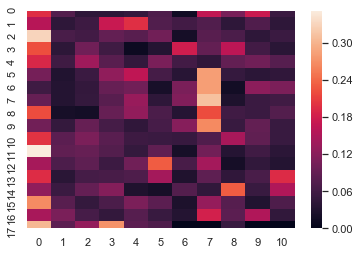

 video_shift index 0 at 00:04:06 , chapter title Introduction ( index 0) 
 video_shift index 1 at 00:06:55 , chapter title Sets ( index 4) 
 video_shift index 2 at 00:08:54 , chapter title Introduction ( index 0) 
 video_shift index 3 at 00:10:39 , chapter title Introduction ( index 0) 
 video_shift index 4 at 00:13:03 , chapter title Introduction ( index 0) 
 video_shift index 5 at 00:14:56 , chapter title Sorting ( index 7) 
 video_shift index 6 at 00:17:42 , chapter title Sorting ( index 7) 
 video_shift index 7 at 00:22:09 , chapter title Sorting ( index 7) 
 video_shift index 8 at 00:24:41 , chapter title Sorting ( index 7) 
 video_shift index 9 at 00:27:11 , chapter title Sorting ( index 7) 
 video_shift index 10 at 00:30:18 , chapter title Introduction ( index 0) 
 video_shift index 11 at 00:33:39 , chapter title Introduction ( index 0) 
 video_shift index 12 at 00:38:24 , chapter title Queues ( index 5) 
 video_shift index 13 at 00:41:42 , chapter title Introduction ( index 0) 

In [20]:
chapters_matching_topics = {}
#for vid in videos_ids:
for vid in [videos_ids[-1]]:
    print('################ %s ################' % (vid))
    paper_name = video_to_paper[vid]
    correlations_levels = []
    
    
    
    '''Finding the correlation between topic and main chapters'''
    main_matching_topic,correlation = get_topic_chapter_corr_tfidf(paper_name,
                                 main_section_as_one_doc[paper_name],
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 paper_content[paper_name]['main titles'])
    
    correlations_levels.append(correlation)
    #print(main_matching_topic)
    knn = 5
    main_matching_topic,main_matching_topic_indexes =  find_dominent_chapter_knn(main_matching_topic,
                                                  paper_content[paper_name]['main titles'],
                                                 correlation,k_nearest = knn)
    
    '''Finding correlation to the first dep sections within the selected main chapter'''
    
    dom_subsec_text = [[first_dep_section_as_one_doc[paper_name][s_i]\
                       for s_i in titles_by_hierchy_ranges[0][dom_cha_index]] for dom_cha_index in main_matching_topic_indexes][0]
    dom_subsec_titles = [[tl_first_dep_by_hier[tl_i]
                         for tl_i in titles_by_hierchy_ranges[0][dom_cha_index]] for dom_cha_index in main_matching_topic_indexes][0]
    print(len(dom_subsec_text))
    print(len(dom_subsec_titles))
    dom_subsec_text = emphasize_title(paper_name,dom_subsec_text,
                                      dom_subsec_titles,lemmatizing = lemmatizing_method)
    
    
    subsec_matching_topic,correlation = get_topic_chapter_corr_tfidf(paper_name,
                                 dom_subsec_text,
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 dom_subsec_titles,is_print_mess=False)

    correlations_levels.append(correlation)
    print(subsec_matching_topic)
    subsec_matching_topic,subsec_matching_topic_indexes =  find_dominent_chapter_knn(subsec_matching_topic,
                                                  subsec_matching_topic,
                                                 correlation,k_nearest = knn)
    print(subsec_matching_topic)
    
    
    section_to_topic = []
    #topics_correlations = []
    '''Finding the third ganular level of chossing the chapter'''
    
    for tp_i,section in enumerate(subsec_matching_topic):
        '''
            Finding the subsections title and texts of the first dep section (4.1 etc)
        '''
        curr_first_dep_tl_index = tl_first_dep_by_hier.index(section)
        subsec_range = titles_by_hierchy_ranges[1][curr_first_dep_tl_index]
        subsection_titles = [paper_content[doc_name]['titles'][tl_i] for tl_i in  subsec_range]
        subsection_text = [paper_subsec_as_one_doc[doc_name][tx_i] for tx_i in subsec_range]
        subsection_text = emphasize_title(paper_name,subsection_text,
                                      subsection_titles,lemmatizing = lemmatizing_method)
        
        topic_matching,topic_corr = get_topic_chapter_corr_tfidf(paper_name,
                                                                 subsection_text,
                                                                 [videos_division[vid]['topic_words'][tp_i]],
                                                                 None,
                                                                 subsection_titles,
                                                                 is_print_mess=False
                                                                )
        section_to_topic = section_to_topic + topic_matching
    
    correlations_levels.append(correlation)
    #measure_confidence(vid,correlations_levels)
    print(len(videos_division[vid]['topic_shift']))
    print(len(section_to_topic))
    df_results = pd.DataFrame(columns=['shift','most_correlated_chapter'])
    df_results['shift'] = videos_division[vid]['topic_shift']
    df_results['most_correlated_chapter'] = section_to_topic
    
    
    

In [21]:
section_to_topic

['1.3\tPseudocode',
 '1.3\tPseudocode',
 '1.3\tPseudocode',
 '1.3\tPseudocode',
 '1.3\tPseudocode',
 '1.3\tPseudocode',
 '1.3\tPseudocode',
 '1.3\tPseudocode',
 '1.3\tPseudocode',
 '1.2.1\tBig Oh notation',
 '1.2.1\tBig Oh notation',
 '1.2.1\tBig Oh notation',
 '1.2.1\tBig Oh notation',
 '1.2.1\tBig Oh notation',
 '1.2.1\tBig Oh notation',
 '1.2.1\tBig Oh notation',
 '1.2.1\tBig Oh notation',
 '1.2.1\tBig Oh notation']

In [22]:
df_google_form = pd.read_csv('../data/raw/forms/form-answers-poc.csv')
mycolumns = [
             '00:00-04:06','04:06-06:55','06:55-08:54',
             '08:54-10:39','10:39-13:03','13:03-14:56',
             '14:56-17:42','17:42-22:09','22:09-24:41',
             '24:41-27:11','27:11-30:18','30:18-33:39',
             '33:39-38:24','38:24-41:42','41:42-45:20',
             '45:20-49:47','49:47-52:52','52:52-53:30',
             'rating_00:00-04:06','rating_04:06-06:55','rating_06:55-08:54',
             'rating_08:54-10:39','rating_10:39-13:03','rating_13:03-14:56',
             'rating_14:56-17:42','rating_17:42-22:09','rating_22:09-24:41',
             'rating_24:41-27:11','rating_27:11-30:18','rating_30:18-33:39',
             'rating_33:39-38:24','rating_38:24-41:42','rating_41:42-45:20',
             'rating_45:20-49:47','rating_49:47-52:52','rating_52:52-53:30'
            ]
df_google_form = df_google_form.drop(columns=['מבין הפרקים הבאים, איזה אחד הכי מתאים לטווח הזמנים: 00:00-04:06 בסרטון'
                                              ,'חותמת זמן','Unnamed: 20'])
df_google_form.columns = mycolumns
df_google_form.columns

Index(['00:00-04:06', '04:06-06:55', '06:55-08:54', '08:54-10:39',
       '10:39-13:03', '13:03-14:56', '14:56-17:42', '17:42-22:09',
       '22:09-24:41', '24:41-27:11', '27:11-30:18', '30:18-33:39',
       '33:39-38:24', '38:24-41:42', '41:42-45:20', '45:20-49:47',
       '49:47-52:52', '52:52-53:30', 'rating_00:00-04:06',
       'rating_04:06-06:55', 'rating_06:55-08:54', 'rating_08:54-10:39',
       'rating_10:39-13:03', 'rating_13:03-14:56', 'rating_14:56-17:42',
       'rating_17:42-22:09', 'rating_22:09-24:41', 'rating_24:41-27:11',
       'rating_27:11-30:18', 'rating_30:18-33:39', 'rating_33:39-38:24',
       'rating_38:24-41:42', 'rating_41:42-45:20', 'rating_45:20-49:47',
       'rating_49:47-52:52', 'rating_52:52-53:30'],
      dtype='object')

In [23]:
df_google_form

,00:00-04:06,04:06-06:55,06:55-08:54,08:54-10:39,10:39-13:03,13:03-14:56,14:56-17:42,17:42-22:09,22:09-24:41,24:41-27:11,...,rating_22:09-24:41,rating_24:41-27:11,rating_27:11-30:18,rating_30:18-33:39,rating_33:39-38:24,rating_38:24-41:42,rating_41:42-45:20,rating_45:20-49:47,rating_49:47-52:52,rating_52:52-53:30
0,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.3 Pseudocode,1.3 Pseudocode,1.2.2 Imperative programming language,...,2,2,1,1,4,4,4,4,4,3
1,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.2.1 Big Oh notation,...,4,3,4,4,1,5,4,4,4,5
2,1.5 Book outline,1.2.1 Big Oh notation,1.6 Testing,1.3 Pseudocode,1.3 Pseudocode,1.6 Testing,1.3 Pseudocode,1.2.1 Big Oh notation,1.6 Testing,1.6 Testing,...,4,3,3,3,5,5,5,5,4,4
3,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,...,1,1,1,1,2,2,1,2,2,2
4,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.2.1 Big Oh notation,...,2,1,3,2,5,5,5,4,2,2
5,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.2.3. Object oriented concepts,1.3 Pseudocode,1.2.1 Big Oh notation,...,3,3,3,3,3,3,4,4,4,3
6,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.2.1 Big Oh notation,1.2.1 Big Oh notation,...,4,4,5,5,5,5,5,5,5,4
7,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.6 Testing,1.6 Testing,1.6 Testing,1.2.1 Big Oh notation,1.2.1 Big Oh notation,...,3,3,4,4,5,5,5,5,5,4


In [24]:
questions = list(filter(lambda x: "rating" not in x,df_google_form.columns))
rating_confidence = list(filter(lambda x: "rating" in x,df_google_form.columns))
chapters_most_frequent = [df_google_form[col].mode().values.tolist() for col in questions]
ratings_avg = [df_google_form[col].mean() for col in rating_confidence]
ratings_var = [df_google_form[col].var() for col in rating_confidence]
df_results['most corr labeled chapters'] = chapters_most_frequent
df_results['rating mean confidence '] = ratings_avg
df_results['rating var confidence '] = ratings_var
df_results['labeled num choices'] = [len(df_google_form[col].value_counts()) for col in questions]
df_results['max entropy'] = [np.log2(len(df_google_form[col].value_counts())) for col in questions]
df_results['labeled choose entropy'] = [entropy(df_google_form[col].value_counts(normalize=True),base=2) for col in questions]
df_results['founded chapter corr'] = [max(topic_correlations) for topic_correlations in correlation]
dom_subsec_titles_ = [re.sub("\t",' ',tl) for tl in dom_subsec_titles]
df_results['labeled chapter corr'] = [[correlation[index][dom_subsec_titles_.index(ch)] for ch in ch_corr_labeled] 
                                      for index,ch_corr_labeled in enumerate(chapters_most_frequent)]
df_results

ValueError: '1.2.1 Big Oh notation' is not in list

In [25]:
hit = 0
miss = 0
for index, row in df_results.iterrows():
    founded_ch = row['most_correlated_chapter']
    labeled_chapters = row['most corr labeled chapters']
    founded_ch = re.sub('\t',' ', founded_ch)
    #col_range_correct = df_google_form.columns[index] + ""
    if founded_ch in labeled_chapters:
        hit+=1
        df_results.loc[index,'range_correct'] = df_google_form.columns[index] + " (HIT)"
    else:
        df_results.loc[index,'range_correct'] = df_google_form.columns[index] + " (MISS)"
        print('miss in %s ' %(index))
        miss+=1
print("hit: %d miss: %s hit ratio: %f" %(hit,miss,hit/(hit+miss)))
df_results['range_correct']

miss in 0 
miss in 1 
miss in 7 
miss in 8 
miss in 17 
hit: 13 miss: 5 hit ratio: 0.722222


0     00:00-04:06 (MISS)
1     04:06-06:55 (MISS)
2      06:55-08:54 (HIT)
3      08:54-10:39 (HIT)
4      10:39-13:03 (HIT)
5      13:03-14:56 (HIT)
6      14:56-17:42 (HIT)
7     17:42-22:09 (MISS)
8     22:09-24:41 (MISS)
9      24:41-27:11 (HIT)
10     27:11-30:18 (HIT)
11     30:18-33:39 (HIT)
12     33:39-38:24 (HIT)
13     38:24-41:42 (HIT)
14     41:42-45:20 (HIT)
15     45:20-49:47 (HIT)
16     49:47-52:52 (HIT)
17    52:52-53:30 (MISS)
Name: range_correct, dtype: object

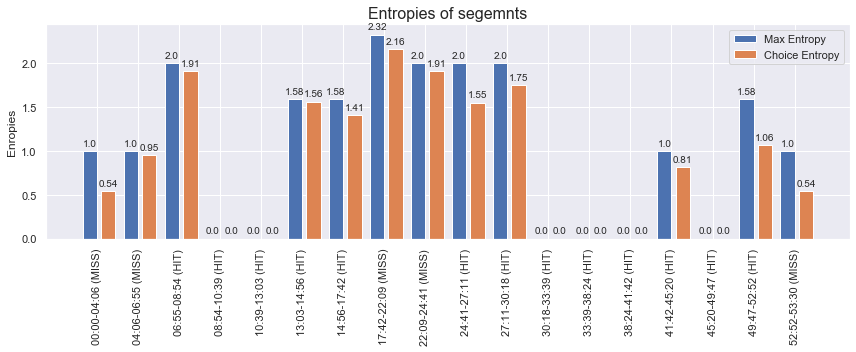

In [26]:


labels = df_results['range_correct'].values.tolist()
max_entropy = df_results['max entropy'].values.tolist()
choice_entropy = df_results['labeled choose entropy'].values.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width/2, max_entropy, width, label='Max Entropy')
rects2 = ax.bar(x + width/2 + 0.1, choice_entropy, width, label='Choice Entropy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enropies')
ax.set_title('Entropies of segemnts',fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 90)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
#fig.figsize = (100,100)



plt.show()

In [27]:
def plot_hist(labels,max_entropy,choice_entropy,title):
    #labels = df_results['range_correct'].values.tolist()
    #max_entropy = df_results['max entropy'].values.tolist()
    #choice_entropy = df_results['labeled choose entropy'].values.tolist()
    epsilon = 0.00001
    normalized_entropy = np.array(list(map(lambda x,y: round(x/(y + epsilon),2),choice_entropy,max_entropy)))
    x = np.arange(len(labels))  # the label locations
    #width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,5))

    levels = [lambda x: x>=0.87,
              lambda x:x<0.87 and x>=0.72,
              lambda x:x<0.72 and x>=0.57,
              lambda x:x<0.57 and x>=0.42,
              lambda x:x<0.42 and x>=0.27,
              lambda x:x<0.27 and x>=0.12,
              lambda x:x<0.12 and x>=0.0]
    masks = [list(map(l,normalized_entropy)) for l in levels]
    colors = ['red','salmon','lightcoral','springgreen','lime','limegreen','green']
    #red_mask =  
    #tomto_mask = #0.7 and choice_entr
    ms = [True] * len(normalized_entropy)

    rects_list = [ax.bar(x[m], normalized_entropy[m], color=c) for c,m in zip(colors,masks)]


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Enropies')
    ax.set_title(title,fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation = 90)
    #ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height,2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    [autolabel(rects) for rects in rects_list]

    fig.tight_layout()
    #fig.figsize = (100,100)



    plt.show()

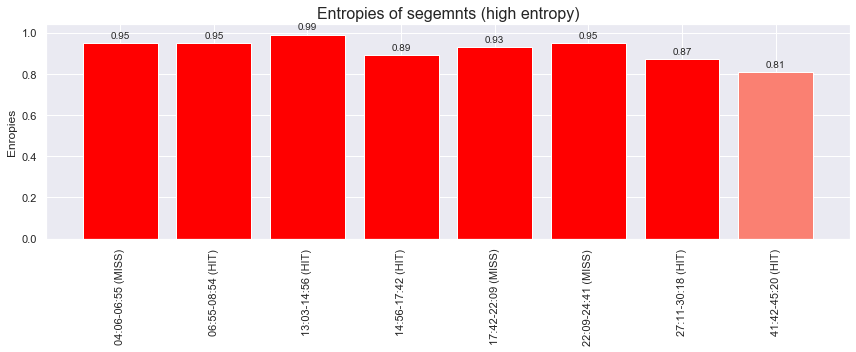

In [28]:
#labels = df_results['range_correct'].values.tolist()
    #max_entropy = df_results['max entropy'].values.tolist()
    #choice_entropy = df_results['labeled choose entropy'].values.tolist()

high_entropy_indexes = [1,2,5,6,7,8,10,14]

plot_hist(df_results.iloc[high_entropy_indexes]['range_correct'].values.tolist(),
          df_results.iloc[high_entropy_indexes]['max entropy'].values.tolist(),
          df_results.iloc[high_entropy_indexes]['labeled choose entropy'].values.tolist(),
         'Entropies of segemnts (high entropy)')

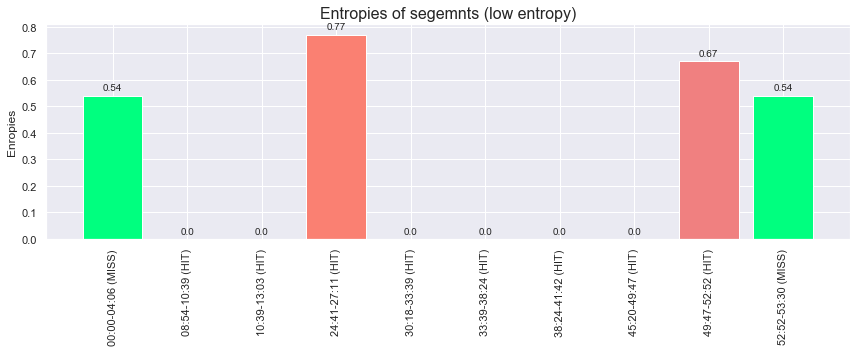

In [29]:
low_entropy_indexes = [i for i in range(len(df_results)) if i not in high_entropy_indexes]
plot_hist(df_results.iloc[low_entropy_indexes]['range_correct'].values.tolist(),
          df_results.iloc[low_entropy_indexes]['max entropy'].values.tolist(),
          df_results.iloc[low_entropy_indexes]['labeled choose entropy'].values.tolist(),
         'Entropies of segemnts (low entropy)')

In [30]:
def hit_ratio(founded_section,labeled_section):
    print('founded_section : %s labeled_section : %s '%(founded_section,labeled_section))
    founded_subsection_nums = founded_section.split('.')
    labeled_subsection_nums = labeled_section.split('.')
    k = min(len(founded_subsection_nums),len(labeled_subsection_nums))
    sub_ratios = []
    for level in range(k):
        my_log = np.log(abs(int(founded_subsection_nums[level]) - int(labeled_subsection_nums[level]) + 1))
        sub_ratios.append(1/((my_log +1) **(level + 1)))
    return sum(sub_ratios)/k

'''Calculate grade for each video matching '''

founded_titles = df_results['most_correlated_chapter'].values.tolist()
founded_sections = list(map(lambda x: re.match(r'((\d+\.)+\d*)',x).groups()[0],founded_titles))
labeled_titles = df_results['most corr labeled chapters'].values.tolist()
labeled_sections = [] #list(map(lambda x: re.match(r'((\d+\.)+\d*)',x).groups()[0],labeled_titles))
for lb_tl_list in labeled_titles:
    labeled_sections.append(list(map(lambda x: re.match(r'((\d+\.)+\d*)',x).groups()[0],lb_tl_list)))

epsilon = 0.00001
normalized_entropy = np.array(list(map(lambda x,y: round(x/(y + epsilon),2),
                                       df_results['labeled choose entropy'].values.tolist(),
                                       df_results['max entropy'].values.tolist())))
cos_normalized_entropy = list(map(lambda x: np.cos(x/180 * np.pi),normalized_entropy))

hit_rates_mult_cos_ent = 0
for found,labels,cos_ent in zip(founded_sections,labeled_sections,cos_normalized_entropy):
    hit_rates_mult_cos_ent += max([hit_ratio(found,lb) * cos_ent for lb in labels])

normalized_factor = sum(list(map(lambda x: np.cos((1/(1+np.exp(-x)))/180 * np.pi),normalized_entropy)))
print(hit_rates_mult_cos_ent/normalized_factor)


founded_section : 1.3 labeled_section : 1.1 
founded_section : 1.3 labeled_section : 1.2.1 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.4 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.4 
founded_section : 1.3 labeled_section : 1.4 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.8 
0.881182752821122


In [32]:
df_results

,shift,most_correlated_chapter,most corr labeled chapters,rating mean confidence,rating var confidence,labeled num choices,max entropy,labeled choose entropy,founded chapter corr,range_correct
0,246,1.3\tPseudocode,"[1.1 What this book is, and what it isn’t]",4.125,1.839286,2,1.000000,0.543564,0.345601,00:00-04:06 (MISS)
1,415,1.3\tPseudocode,[1.2.1 Big Oh notation],3.125,1.839286,2,1.000000,0.954434,0.570819,04:06-06:55 (MISS)
2,534,1.3\tPseudocode,[1.3 Pseudocode],4.000,1.714286,4,2.000000,1.905639,0.280421,06:55-08:54 (HIT)
3,639,1.3\tPseudocode,[1.3 Pseudocode],2.750,1.642857,1,0.000000,0.000000,0.481647,08:54-10:39 (HIT)
4,783,1.3\tPseudocode,[1.3 Pseudocode],3.250,1.642857,1,0.000000,0.000000,0.514455,10:39-13:03 (HIT)
5,896,1.3\tPseudocode,"[1.3 Pseudocode, 1.4 Tips for working through ...",4.125,0.982143,3,1.584963,1.561278,0.529940,13:03-14:56 (HIT)
6,1062,1.3\tPseudocode,[1.3 Pseudocode],3.375,1.982143,3,1.584963,1.405639,0.397623,14:56-17:42 (HIT)
7,1329,1.3\tPseudocode,[1.4 Tips for working through the examples],3.000,1.714286,5,2.321928,2.155639,0.280353,17:42-22:09 (MISS)
8,1481,1.3\tPseudocode,[1.4 Tips for working through the examples],2.875,1.267857,4,2.000000,1.905639,0.613204,22:09-24:41 (MISS)
9,1631,1.2.1\tBig Oh notation,[1.2.1 Big Oh notation],2.500,1.142857,4,2.000000,1.548795,0.386460,24:41-27:11 (HIT)


In [33]:
df_results['normalized entropy'] = np.array(list(map(lambda x,y: round(x/(y + epsilon),2),df_results['labeled choose entropy'].values.tolist(),df_results['max entropy'].values.tolist())))

In [36]:
bounds = [0,0.5,0.9,1]
rate_success = []
ranges_ = []
for bnd_i in range(1,len(bounds)):
    min_ = bounds[bnd_i - 1]
    max_ = bounds[bnd_i]
    segments_res = df_results[(df_results['normalized entropy'] < max_) & (df_results['normalized entropy'] >= min_)]['range_correct'].values.tolist() 
    count_hit  = reduce(lambda acc,x: acc+1 if 'HIT' in x else acc+0,segments_res,0)
    rate_success.append(count_hit/len(segments_res) * 100)
    ranges_.append("%s-%s"%(min_,max_))

No handles with labels found to put in legend.


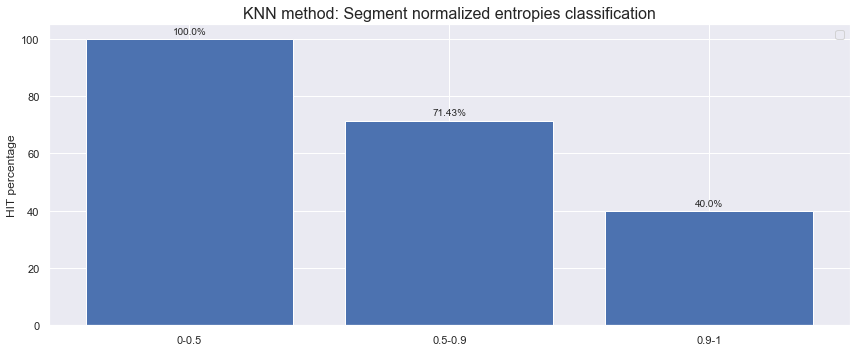

In [38]:
fig, ax = plt.subplots(figsize=(12,5))
x = np.arange(len(ranges_))
rects = ax.bar(x, rate_success) 
ax.set_ylabel('HIT percentage')
ax.set_title('KNN method: Segment normalized entropies classification',fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(ranges_)
ax.legend()

for rect in rects:
    height = rect.get_height()
    ax.annotate('{}%'.format(round(height,2)),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
fig.tight_layout()
plt.show()